This notebook implements a GMM for the regression task.

In [11]:
# Standard Python Imports
import os
import matplotlib.pyplot as plt

# Extra non-standard utilities
from argparse import Namespace


# Data management and Math imports
import numpy as np
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import copy

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression

from scipy.special import logsumexp

In [2]:
args = Namespace(
   seed=5059 
) 

In [3]:
rng = np.random.default_rng(args.seed)

# 1 Load in Data

In [4]:
dataDir = "NumpyData/"

In [5]:
X_train_processed = np.load(dataDir + 'X_train_prepared.npy')
X_test_processed = np.load(dataDir + 'X_test_prepared.npy')
X_val_processed = np.load(dataDir + 'X_val_prepared.npy')

y_train_processed = np.load(dataDir + 'y_train_prepared.npy')
y_test_processed = np.load(dataDir + 'y_test_prepared.npy')
y_val_processed = np.load(dataDir + 'y_val_prepared.npy')

y_train = np.load(dataDir + 'y_train.npy')
y_val = np.load(dataDir + 'y_val.npy')
y_test = np.load(dataDir + 'y_test.npy')

Combine train and validation data - no need for validation

In [6]:
X_train_processed =  np.vstack((X_train_processed, X_val_processed))
y_train_processed =  np.vstack((y_train_processed, y_val_processed))
y_train = np.concatenate((y_train, y_val))

# 2 First principles GMM

## 2.1 Expectation Step

Gaussian Log Likelihood
$$\begin{align}
    P(x|\sigma_k^2,\mu_k) = -\frac{n}{2}\ln(2\pi\sigma^{2}_k) - \frac{1}{2\sigma^{2}}\sum_{i=1}^n (x - \mu_k)^2
\end{align}$$
Hence we have responsibility assignment:
$$\begin{align}
    r_{ik} = \ln\pi_k - \frac{d}{2}\ln(2\pi) - \frac{1}{2}\ln|\Sigma_{k}| - \frac{1}{2}(x^{(i)} - \mu_k)^{T}\Sigma_{k}^{-1}(x^{(i)} - \mu_k) \\ - \ln \left \{ \sum_{k'}^{K} \pi_{k'} + \exp \left \{ -\frac{1}{2}(x^{(i)} - \mu_{k'})^{T}\Sigma_{k'}^{-1}(x^{(i)} - \mu_{k'}) \right \} \right \} 
\end{align}$$

In [15]:

def e_step(X, πs, μs, Σs, eps=1e-14):

    n, d = X.shape
    K = len(πs)
    
    # Responsibility matrix
    R = np.zeros((n, K))
    
    for k in range(K):
        # Calculate the inverse of the covariance matrix and its determinant
        sigma_inv = np.linalg.inv(Σs[k])
        sigma_det = np.linalg.det(Σs[k])
        
        # Compute the log-likelihood for each data point and each cluster
        diff = X - μs[k]  # Shape (n, d)
        exponent = np.sum(diff @ sigma_inv * diff, axis=1)  # Shape (n,)
        
        # Log of the Gaussian component likelihood
        log_likelihood_k = -0.5 * (d * np.log(2 * np.pi + eps) + np.log(sigma_det + eps) + exponent)
        
        # Update responsibility matrix using the log of the likelihood
        R[:, k] = np.log(πs[k] + eps) + log_likelihood_k
    
    # Compute the log-sum-exp to normalize the responsibilities (numerically stable)
    log_R_norm = np.log(np.sum(np.exp(R), axis=1, keepdims=True) + eps)
    
    # Normalize the responsibilities so they sum to 1 across clusters for each data point
    R = np.exp(R - log_R_norm)  # This is the responsibility matrix
    
    # Compute the total log-likelihood of the data
    loglik = np.sum(log_R_norm)  # Sum of the log of the norm across all data points
    
    return R, loglik


## 2.2 Maximization Step

Update $\mu_{k}$, $\pi_{k}$, $\Sigma_{k}$ : 
$$\begin{align}
    \mu_{k} &= \frac{1}{\sum^{n}_{i=1} r_{ik}}\\
    \pi_{k} &= \frac{1}{n} \sum^{n}_{i=1} r_{ik}\\
    \Sigma_{k} &= \frac{1}{\sum^{n}_{i=1} r_{ik}} \sum^{n}_{i=1}r_{ik}(x^{(i)}-\mu_{k})(x^{(i)}-\mu_{k})^T
\end{align}$$


In [14]:
def m_step(X, R, eps=1e-14):
    n, d = X.shape  # n is number of data points, d is the dimensionality
    K = R.shape[1]  # K is the number of components (clusters)
    
    # Initialize parameters
    πs = np.zeros(K)
    μs = np.zeros((K, d))
    Σs = np.zeros((K, d, d))
    
    # Update the priors (weights) pi_k
    πs = np.sum(R, axis=0) / n
    
    # Update the means (mu_k) for each component
    for k in range(K):
        μs[k] = np.sum(R[:, k][:, np.newaxis] * X, axis=0) / np.sum(R[:, k])
    
    # Update the covariance matrices (Sigma_k) for each component
    for k in range(K):
        diff = X - μs[k]
        Σs[k] = np.dot((R[:, k][:, np.newaxis] * diff).T, diff) / np.sum(R[:, k])
        
        # Ensure the covariance matrix is positive semi-definite (optional)
        Σs[k] += np.eye(d) * eps  # Add small regularization term
    
    return πs, μs, Σs


## 2.3 EM Algorithm

In [70]:
def em_mixgauss(X, K, tol = 1e-4, maxIters = 100):
	## initilisation
	n, d = X.shape
	
	R = rng.random((n, K))

	# normalize initialization responsibility matrix 
	R /= np.sum(R, axis=1, keepdims=True)

	# perform maximization step
	πs, μs, Σs = m_step(X,R)

	logLiks = [0.0]

	for i in range(maxIters):
		# E step 
		R, loglik = e_step(X, πs, μs, Σs)
		logLiks.append(loglik)

		# M step 
		πs, μs, Σs = m_step(X, R)
		

		# Check for convergence 
		if np.abs(logLiks[-1] - logLiks[-2]) < tol:
			break 
		
	zs = np.argmax(R, axis=1)

	return logLiks, πs, μs, zs, Σs, R



In [40]:
def find_best_results(trials, X, K=10, tol=1e-4, maxIters=100):
    ''' 
        Runs a number of trials of kmeans to produce cluster assignments with the lowest loss

        @param (trials) : integer number of trials to run
        @param (X) : the data matrix
    '''

    best = np.inf
    l = None
    z = None
    μ = None
    Σ = None
    π = None
    for i in range(0,trials):
        logLiks, πs, μs, zs, Σs, R = em_mixgauss(X, K, tol, maxIters)
        mean_loss = np.mean(logLiks)
        if mean_loss < best:
            best = mean_loss
            l = logLiks
            z = zs
            μ = μs 
            Σ = Σs
            π = πs

    return l, π, μ, z, Σ

## 2.4 Prediction Function

In [67]:
def predict(X_test, μs, πs, Σs, zs, eps=1e-14):
    # Number of test samples and components
    n_test, d = X_test.shape
    K = len(πs)
    
    # Initialize predicted labels array
    y_preds = np.zeros(n_test)
    
    # Compute the likelihood for each test data point under each Gaussian component
    for i in range(n_test):
        # For each test point, compute the Gaussian component likelihoods
        likelihoods = np.zeros(K)
        
        for k in range(K):
            # Inverse and determinant of covariance matrix for the k-th component
            sigma_inv = np.linalg.inv(Σs[k])
            sigma_det = np.linalg.det(Σs[k])
            
            # Compute the Mahalanobis distance between X_test[i] and mu[k]
            diff = X_test[i] - μs[k]
            exponent = np.dot(np.dot(diff, sigma_inv), diff)
            
            # Compute the Gaussian likelihood for this component
            likelihoods[k] = np.log(πs[k] + eps) - 0.5 * (d * np.log(2 * np.pi + eps) + np.log(sigma_det + eps) + exponent)
        
        # Find the most likely component for the current test data point
        pred_z = np.argmax(likelihoods)  # Predicted cluster index for this test data point
        
        # Get the training data points assigned to the predicted cluster `pred_z`
        cluster_indices = np.where(zs == pred_z)[0]  # Find training points assigned to the predicted cluster
        
        # Compute the average y-value for the assigned cluster
        y_preds[i] = np.mean(y_train[cluster_indices])  # Use the average y-value of those points
    
    
    return y_preds

In [77]:
def predict_sim(X_test, us, zs, y_train):
    K, d = us.shape

    zs = np.eye(K)[zs] # one-hot encode

    # Normalize input vectors 
    X_test_norm = np.linalg.norm(X_test, axis=1, keepdims=True)
    X_test_normalized = X_test/X_test_norm
    # Normalize cluster means
    us_norm = np.linalg.norm(us, axis=1, keepdims=True)
    us_normalized = us / us_norm

    # Compute similarities 
    similarities = np.dot(X_test_normalized, us_normalized.T)

    # Compute assignments for test inputs
    pred_zs = np.argmax(similarities, axis=1)

    # compute sum of labels for train data, per cluster
    sums = np.dot(zs.T, y_train)

    # get number of train datapoints assigned per cluster
    counts = np.sum(zs, axis=0)

    # compute average
    means = sums/counts 

    # assign averages to test data predictions
    y_preds = means[pred_zs]

    return y_preds

In [89]:
logLiks, πs, μs, zs, Σs = find_best_results(3, X_train_processed, K=100)

In [90]:
y_preds = predict(X_test_processed, μs, πs, Σs, zs)

# 3 Evaluation

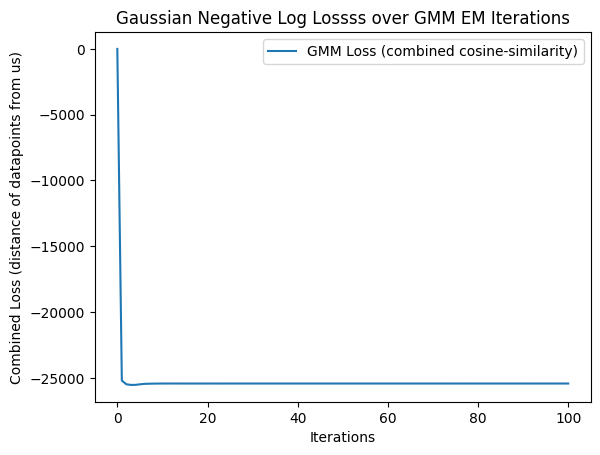

In [91]:
plt.plot(logLiks, label="GMM Loss (combined cosine-similarity)")
plt.title("Gaussian Negative Log Lossss over GMM EM Iterations")
plt.xlabel("Iterations")
plt.ylabel("Combined Loss (distance of datapoints from us)")
plt.legend()
plt.show()

In [92]:
gmm_mse = np.sqrt(mean_squared_error(y_preds, y_test))

In [93]:
print("GMM MSE : ", gmm_mse)

GMM MSE :  969.5502037743528


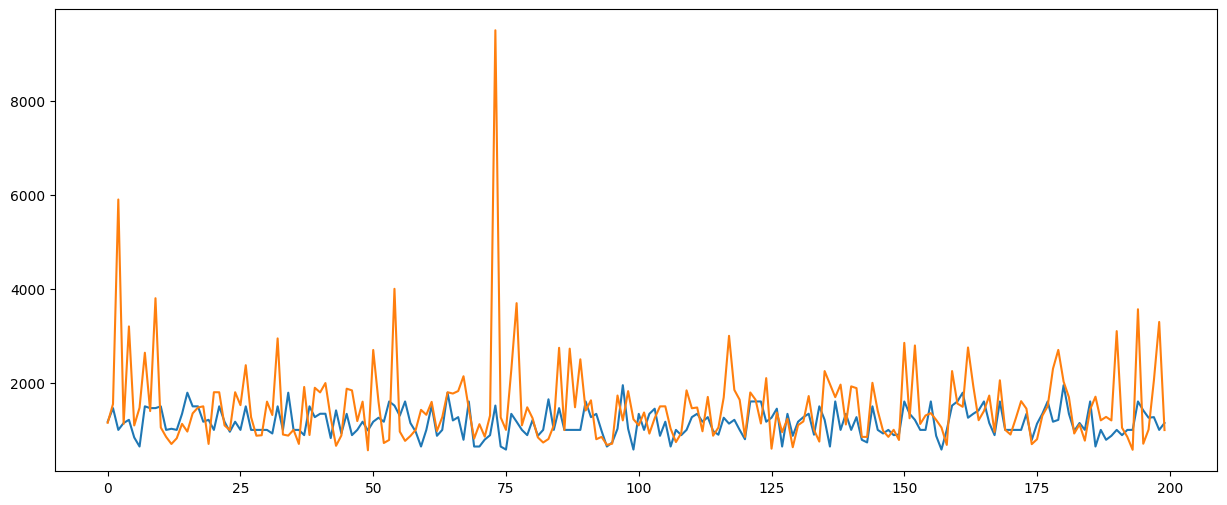

In [94]:
plt.figure(figsize=(15,6))

plt.plot([i for i in range(len(y_test))], y_preds)
plt.plot([i for i in range(len(y_test))], y_test)